In [1]:
%matplotlib notebook

In [23]:
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt

In [3]:
from viz_utils import *


DMP Viz Tools
Git Commit Hash: b2f0a6b
Hostname: jperrsau-33730s
Date: 2021-11-23 15:50:34.398898



In [4]:
clear_cache()

## Explore Fixed 3K Notebook

- Review the finished experiments that are in the refactored, materialized table.
- Create an array of visualizations to inspect the quality of the results.
-- Are we collecting the data we think we're collecting?
-- Do any experiments need to be re-run?

## Data Completeness
Histograms and contingency tables

In [18]:
query_string = f'''
select  budget,
        "group",
        dataset,
        learning_rate,
        label_noise,
        topology,
        residual_mode,
        depth,
        count(*) as count
from materialized_experiments_3_base
group by budget,
        "group",
        dataset,
        learning_rate,
        label_noise,
        topology,
        residual_mode,
        depth
'''
df = cached_query(query_string)
to_string = ["group", "dataset", "topology", "residual_mode"]
df = df.apply(lambda x: id_to_string(x) if x.name in to_string else x)

<IPython.core.display.Javascript object>


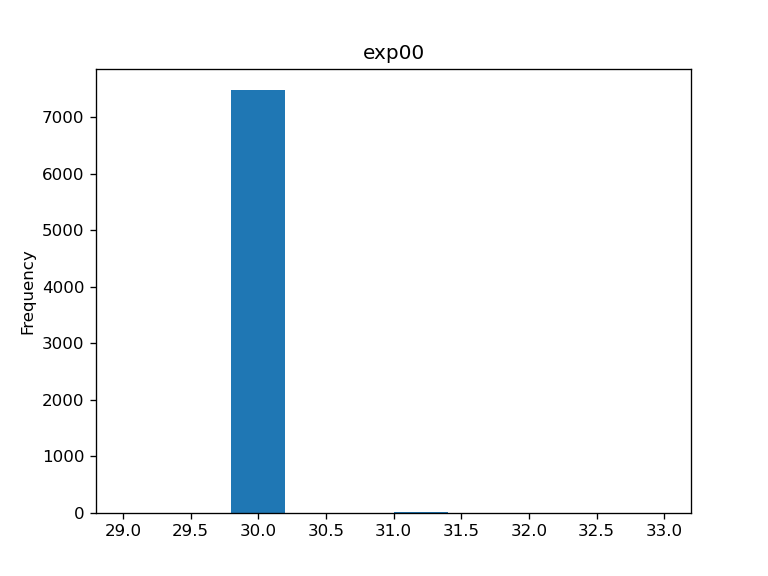

<IPython.core.display.Javascript object>


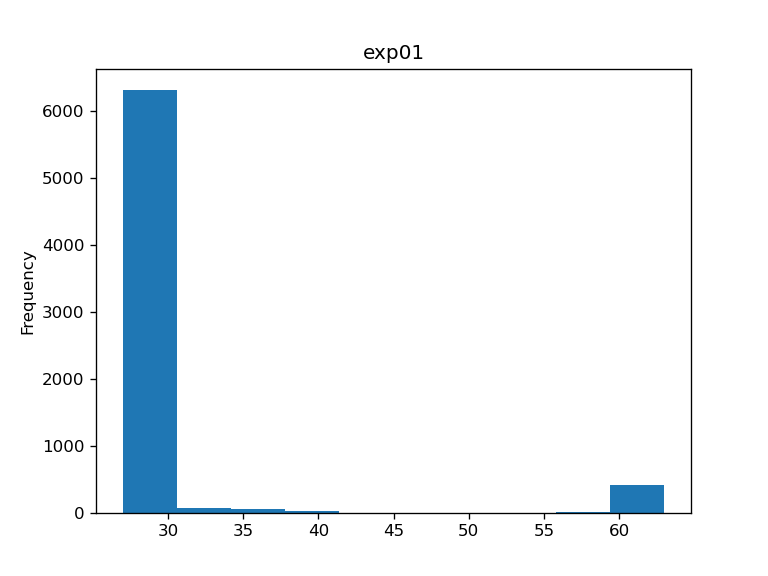

<IPython.core.display.Javascript object>


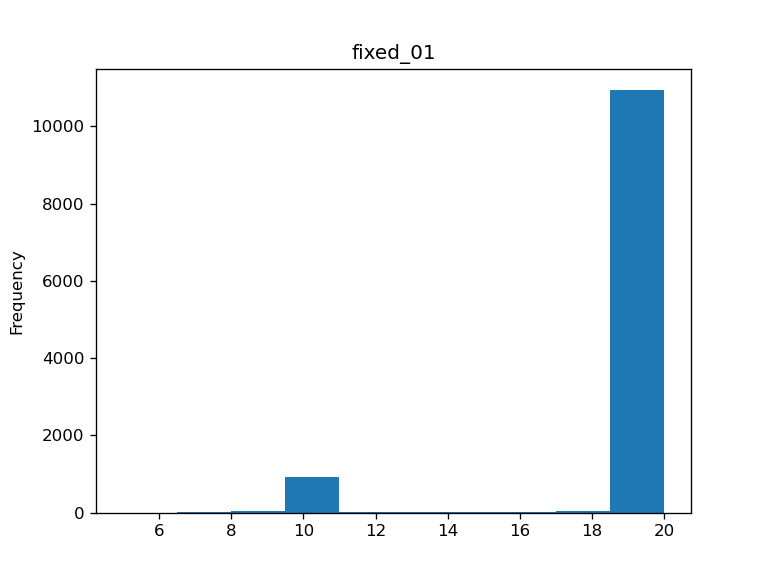

<IPython.core.display.Javascript object>


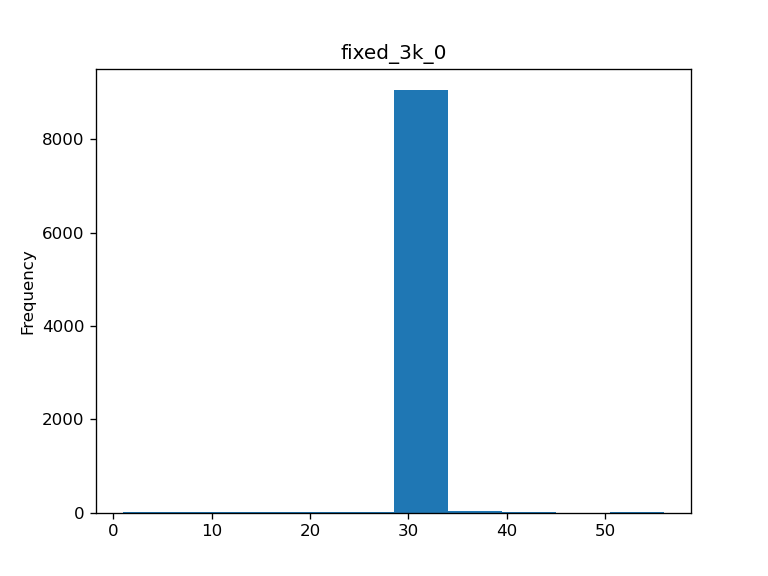

<IPython.core.display.Javascript object>


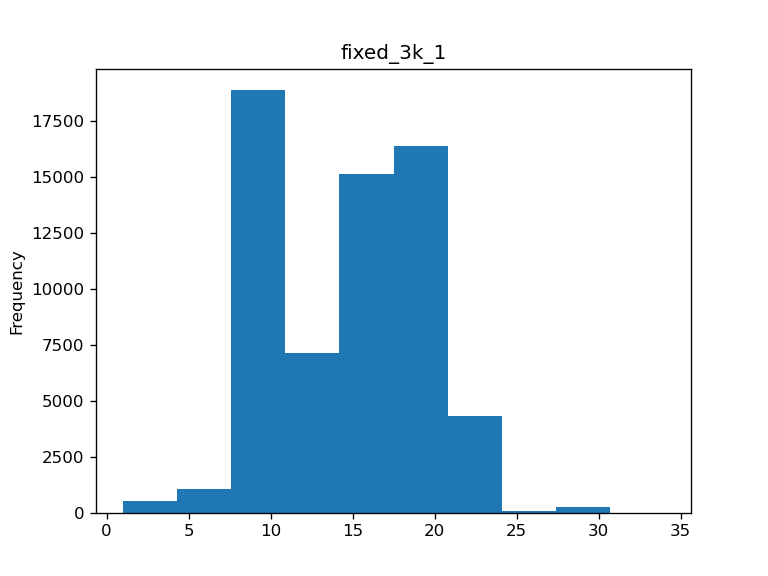

In [26]:
for group, gdf in df.groupby("group"):
    plt.figure()
    gdf["count"].plot.hist()
    plt.title(group)
    plt.show()

In [40]:
data = df[df["group"] == "fixed_3k_1"].groupby(["depth","dataset"]).sum()["count"].unstack()

px.imshow(data,
         title="fixed_3k_1 counts")

In [42]:
data = df[df["group"] == "fixed_3k_1"].groupby(["topology","label_noise"]).sum()["count"].unstack()

px.imshow(data,
         title="fixed_3k_1 counts")

In [43]:
data = df[df["group"] == "fixed_3k_1"].groupby(["dataset","label_noise"]).sum()["count"].unstack()

px.imshow(data,
         title="fixed_3k_1 counts")

In [44]:
data = df[df["group"] == "fixed_3k_1"].groupby(["dataset","learning_rate"]).sum()["count"].unstack()

px.imshow(data,
         title="fixed_3k_1 counts")

In [41]:
df[df["group"] == "fixed_3k_1"]

,budget,group,dataset,learning_rate,label_noise,topology,residual_mode,depth,count
537,32,fixed_3k_1,201_pol,0.0001,0.00,rectangle,none,2,30
538,32,fixed_3k_1,201_pol,0.0001,0.00,rectangle,none,3,30
539,32,fixed_3k_1,201_pol,0.0001,0.00,rectangle,none,4,30
540,32,fixed_3k_1,201_pol,0.0001,0.00,rectangle,none,5,30
541,32,fixed_3k_1,201_pol,0.0001,0.00,rectangle,none,7,30
...,...,...,...,...,...,...,...,...,...
96147,16777216,fixed_3k_1,sleep,0.0010,0.05,wide_first_2x,none,12,2
96148,16777216,fixed_3k_1,sleep,0.0010,0.05,wide_first_2x,none,14,2
96149,16777216,fixed_3k_1,sleep,0.0010,0.05,wide_first_2x,none,16,3
96150,16777216,fixed_3k_1,sleep,0.0010,0.05,wide_first_2x,none,18,1


In [ ]:
### Heapmap App using Imshow

@interact_manual(**options, viz=["imshow", "scatter"])
def heatmap_app(groups="('exp00', 'exp01')", dataset="537_houses", topology="wide_first", loss="history_val_mean_squared_error", agg="avg", residual_mode="none", viz="imshow"):
    query_string = f'''
select "config.budget", {agg}(a.val) as value, count(a.val), a.epoch
from
    materialized_experiments_0 t,
    unnest(t.{loss}) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname" IN {groups} and
    "config.dataset"='{dataset}' and
    "config.topology"='{topology}' and
    "config.residual_mode"='{residual_mode}'
GROUP BY epoch, "config.budget"
'''
    df = cached_query(query_string)
    
    if viz == "imshow":
        #df = df.query("count > 389")
        df["value"] = np.log(df["value"])
        img = df.pivot_table(columns="epoch", index="config.budget", values="value")
        img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
        return px.imshow(img)
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        return px.scatter(df, x="epoch", y="config.budget", size="count", color="value")

In [8]:
### Heapmap App using Imshow

@interact_manual(**options, 
                 viz=["imshow", "scatter", "effort"], 
                 depths=widgets.IntRangeSlider(min=2, max=20, step=1, value=(2,20)))
def heatmap_app(
    group='fixed_3k_1',
    learning_rate=0.0001,
    label_noise = 0.0,
    dataset="201_pol", 
    topology="trapezoid", 
    residual_mode="none",
    loss="val_loss", 
    agg="avg",
    viz="effort", 
    depths=(2,20),
    color_range=1.3):
    history_table = 'materialized_experiments_3_val_loss' if loss == 'val_loss' else \
        'materialized_experiments_3_history'
    query_string = f'''
    select budget, {agg}(a.val) as value, count(a.val) as count, a.epoch
    from
        materialized_experiments_3_base base,
        {history_table} history,
        unnest(history.{loss}) WITH ORDINALITY as a(val, epoch)
    WHERE
        base.id = history.id and
        "group" = {string_to_id(group)} and
        dataset = {string_to_id(dataset)} and
        learning_rate = {learning_rate}::real and
        label_noise = {label_noise}::real and
        topology = {string_to_id(topology)} and
        residual_mode = {string_to_id(residual_mode)} and
        depth BETWEEN {depths[0]} and {depths[1]}
    GROUP BY budget, epoch
    ORDER BY budget, epoch;
    '''
    print('Querying...')
    df = cached_query(query_string)
    print('done.')
    
    df = cached_query(query_string)

    #df = df.query("count > 389")
    df["value"] = np.log(df["value"])
    img = df.pivot_table(columns="epoch", index="budget", values="value")
    img.index = img.index.astype("str") #plotly interprets the y axis as numeric otherwise
    return px.imshow(img)
    
    
    #return make_2d_heatmap_viz(df, group, dataset, topology, loss, agg, residual_mode, viz, color_range)

interactive(children=(Dropdown(description='group', options=('fixed_3k_1', 'fixed_3k_0', 'fixed_01', 'exp00', …